<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Tutorial: Custom Filters in OSMnx</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Jan Leonard Schelhaas</h3>
</div>

In today's tutorial we will see how you can work with custom filters in OSMnx.

The notebook is partially based on the OSMnx [tutorial on custom filtering](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/08-custom-filters-infrastructure.ipynb).

### What is custom filtering?

To use a custom filter simply means that you, instead of getting all data for an area, use some condition/filter, which only returns a subset of the data (based on the OSM tag value).

OSMnx has support for [applying custom filters](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/08-custom-filters-infrastructure.ipynb), which allows you to create a network with a subset of all available edges, depending on some criteria.

The custom filtering is quering the [OSM Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API).

### Why use custom filters?
We will often not want to get *all* of the streets and paths included in the OSM data for an area.

OSMnx supports some simple build-in network types ("all_private", "all", "bike", "drive", "drive_service", "walk") based on where it is *allowed* to drive/bike/walk.

Just because it in theory is allowed to e.g. bike somewhere does however not mean that people actually do/can bike there, so we might want to only include the edges with a certain type of infrastructure or some other attribute.


In [20]:
# import libraries needed
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandas as pd

%matplotlib inline
ox.__version__

'1.1.2'

### Simple custom filters

In [2]:
place = {"city": "Berkeley", "state": "California"}

# only get motorway ways
cf = '["highway"~"motorway"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "motorway")

# use the pipe (|) as 'or' operator
cf = '["highway"~"motorway|primary"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "motorway + primary")

34 motorway
45 motorway + primary


**It is also possible to use custom filters for other objects than just street networks:**

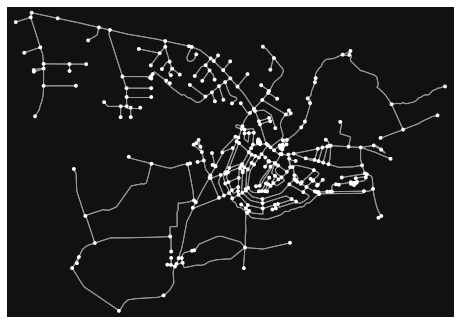

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc1b5ebdc40>)

In [3]:
# network of the canals of amsterdam
place = "Amsterdam, Netherlands"
G = ox.graph_from_place(place, custom_filter='["waterway"~"canal"]')

ox.plot_graph(G)

### Combining multiple custom filters


An issue with the custom filtering is that it is not that well suited for having multiple conditions at the same time.

One way of solving it is to create a custom filter for each tag you are interested in and use them to create subgraphs, which at the end are merged into one final network.

The example below is based on [Michaels research](https://github.com/mszell/bikenwgrowth/blob/master/parameters/parameters.py) and creates a network with all designated cycling infrastructure + streets with a max speed of 30 km/h.

In [4]:
place = 'Frederiksberg Municipality'

# custom filter for all cycling infrastructure
cf_bike = {'bike_cyclewaytrack': '["cycleway"~"track|lane|opposite_lane|opposite_track|shared_lane|designated"]',
            'bike_highwaycycleway': '["highway"~"cycleway"]',
            'bike_cyclewayrighttrack': '["cycleway:right"~"track|lane|opposite_lane|opposite_track|shared_lane|designated"]',
            'bike_cyclewaylefttrack': '["cycleway:left"~"track|lane|opposite_lane|opposite_track|shared_lane|designated"]',
            'bike_cyclestreet': '["cyclestreet"]',
            'bike_bicycleroad': '["bicycle_road"]',
            'bike_livingstreet': '["highway"~"living_street"]'
            } 

bike_graphs = []

for graph_type, cf in cf_bike.items():
    try:
        G_bike =  ox.graph_from_place(place, network_type='all', retain_all=True, custom_filter=cf)
        bike_graphs.append(G_bike)
    except ValueError:
        print(f'No data returned for {graph_type}!')
        continue

G_bike = nx.compose_all(bike_graphs)


No data returned for bike_cyclestreet!
No data returned for bike_bicycleroad!


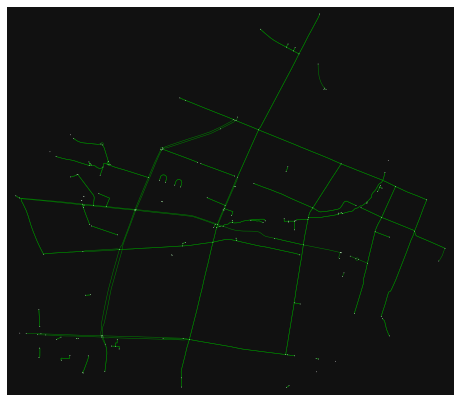

In [5]:
# Plot
ox.plot_graph(G_bike, node_size=0.5, edge_color="green", edge_linewidth=0.5);

### Filter using GeoPandas and query

Another option is to convert the full network to a GeoDataFrame with edges, retrieve the relevant edges, and rebuild the graph from those.
The example here uses a list of different queries to build a network of cycling infrastructure.

The core idea is to: 
- first get the subset of the edges we are interested in, 
- then get subset of the nodes referenced by these edges and, 
- finally create a new graph based on the selection of edges and corresponding nodes.

When using this method you have to make sure that the tag you are interested in actually are downloaded from OSM *before* querying the edges.
By default, only a small number of tags are included:


In [8]:
graph = ox.graph_from_place(place, network_type='bike', simplify=False, retain_all=True, truncate_by_edge=False, clean_periphery=True)

edges = ox.graph_to_gdfs(graph, nodes=False)

edges.columns

Index(['osmid', 'name', 'highway', 'maxspeed', 'oneway', 'length', 'lanes',
       'junction', 'bridge', 'service', 'access', 'width', 'tunnel',
       'geometry'],
      dtype='object')

We can change which tags are downloaded from OSM by updating the OSMnx configurations.

Note that if none of the returned features have a value for a given tag, the tag will not be included even though it has been specified as a 'useful tag'.

In [9]:
osm_way_tags = ['access', 'barrier', 'bridge', 'bicycle', 'bicycle_road', 'crossing', 'cycleway', 'cycleway:left', 
                'cycleway:right', 'cycleway:both', 'cycleway:buffer', 'cycleway:left:buffer', 'cycleway:right:buffer', 'cycleway:both:buffer', 'cycleway:width', 'cycleway:left:width', 
                'cycleway:right:width', 'cycleway:both:width', 'cycleway:surface', 'foot', 'footway', 'highway', 'inclince', 'junction', 'layer', 'lit', 'maxspeed', 'maxspeed:advisory', 
                'moped', 'moter_vehicle', 'motorcar', 'name', 'oneway', 'oneway:bicycle', 'osm_id', 'segregated', 'surface', 'tracktype', 'tunnel', 'width']

ox.utils.config(use_cache=True, 
    useful_tags_way = osm_way_tags)

**Now we have more attributes in our edge GeoDataFrame:**

In [41]:
graph = ox.graph_from_place(place, network_type='bike', simplify=False, retain_all=True, truncate_by_edge=False, clean_periphery=True)

nodes, edges = ox.graph_to_gdfs(graph)

edges.columns 

Index(['osmid', 'bicycle', 'cycleway', 'foot', 'highway', 'lit', 'maxspeed',
       'name', 'surface', 'oneway', 'length', 'cycleway:right',
       'maxspeed:advisory', 'junction', 'oneway:bicycle', 'bridge', 'layer',
       'cycleway:both', 'cycleway:left', 'motorcar', 'segregated',
       'cycleway:right:width', 'moped', 'access', 'width', 'cycleway:surface',
       'tunnel', 'geometry'],
      dtype='object')

**We will need one helper function for creating our graph at the end:**

In [21]:
def create_cycling_network(new_edges, original_nodes, original_graph, return_nodes=False):
    # Create new OSMnx graph from a subset of edges of a larger graph

    #Getting a list of unique nodes used by bike_edges
    new_edges_index = pd.MultiIndex.to_frame(new_edges.index)
    u = new_edges_index['u'].to_list()
    v = new_edges_index['v'].to_list()

    used_nodes = list(set().union(u,v))

    #All nodes are copied to an new dataframe
    new_nodes = original_nodes.copy(deep=True)

    #Creating new column in bike_nodes with the index value
    new_nodes['osmid'] = new_nodes.index

    #Using list of nodes to mask out unnecessary nodes
    new_nodes = new_nodes[new_nodes['osmid'].isin(used_nodes)]

    #Drop column - not needed anymore 
    new_nodes.drop(columns='osmid', inplace=True)

    #Create graph from nodes and edge geodataframe
    new_graph = ox.graph_from_gdfs(new_nodes, new_edges, graph_attrs=original_graph.graph)

    if return_nodes:
        return new_graph, new_nodes
    
    else:
        return new_graph

**...and one function for cleaning up column names** (the ':' in OSM tag names can sometimes cause problems...)

In [23]:
def clean_col_names(df):
    '''
    Remove upper-case letters and : from OSM key names
    '''
    df.columns = df.columns.str.lower()

    df_cols = df.columns.to_list()

    new_cols = [c.replace(':','_') for c in df_cols]

    df.columns = new_cols

    return df

**Quering our edges:**

In [53]:
# Clean up column names (removing ':' and upper case letters)
edges = clean_col_names(edges)
nodes = clean_col_names(nodes)

edges['cycling_infrastructure'] = 'no'

queries = ["highway == 'cycleway'",
        "highway == 'living_street'",
        "cycleway in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
        "cycleway_left in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
        "cycleway_right in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
        "cycleway_both in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
        "highway == 'track' & bicycle in ['designated','yes']",
        "highway == 'service' & bicycle == 'designated'",
        "bicycle_road == 'yes'",
        "highway == 'path' & bicycle in ['designated','yes']"
        ]

for q in queries:
    try:
        ox_filtered = edges.query(q)

        edges.loc[ox_filtered.index, 'cycling_infrastructure'] = 'yes'
    
    except Exception:
        print('Exception occured when quering with:', q)

cycling_edges = edges.loc[edges.cycling_infrastructure == 'yes']

print(len(edges))
print(len(cycling_edges))

Exception occured when quering with: bicycle_road == 'yes'
18242
3622


In [40]:
cycling_graph = create_cycling_network(cycling_edges, nodes, graph, return_nodes=False)

**Plotting the two graphs shows us the result:**

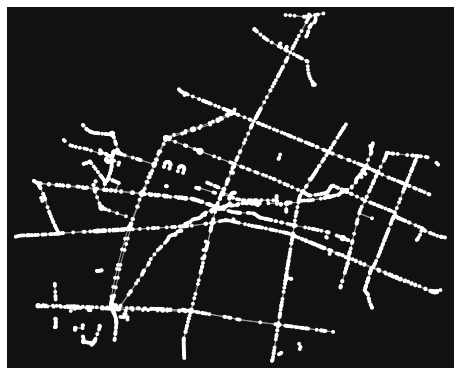

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc19f988460>)

In [38]:
ox.plot_graph(cycling_graph)

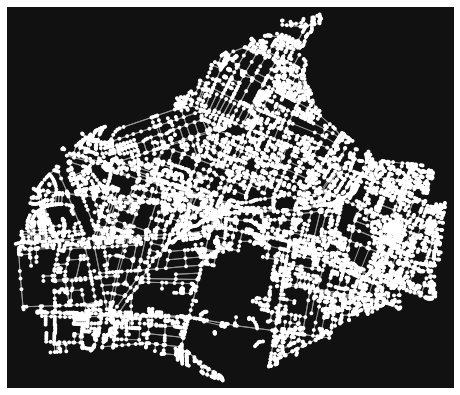

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc19e096310>)

In [36]:
ox.plot_graph(graph)

This method is useful for using more complex filters and for situations where you anyway need all the edges as a GeoDataFrame for other purposes. 

The drawback is that you have to know what tags are in the retrieved data from OSM beforehand or use some method for cathing errors if the tag you are quering for do not exist in the data.